In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
x_train_nhts = np.load("x_train100k.npy")[:,1:]
x_test_nhts = np.load("x_test100k.npy")[:,1:]

y_train = np.load("y_train_hhvehcnt100k.npy")
y_test = np.load("y_test_hhvehcnt100k.npy")
print("The sample size of training set is: ", x_train_nhts.shape[0])
print("The sample size of testing set is: ", x_test_nhts.shape[0])

The sample size of training set is:  100000
The sample size of testing set is:  10000


In [4]:
print(x_train_nhts.shape)
print(y_train.shape)
print(x_train_nhts[0])
print(y_train[0])

(100000, 87)
(100000, 1)
[0.         0.         1.         0.         0.22222222 0.
 0.         0.         0.         1.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.08333334
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         1.         0.38999999 0.         1.         1.
 0.         0.         0.        ]
[2]


In [5]:
# bridge numpy to torch
x_train_nhts_torch = torch.as_tensor(x_train_nhts).float() # specify floats for the inputs
x_test_nhts_torch = torch.as_tensor(x_test_nhts).float()
y_train_torch = torch.as_tensor(y_train[:,0])
y_test_torch = torch.as_tensor(y_test[:,0])
n_train = x_train_nhts.shape[0]
n_test = x_test_nhts.shape[0]
# inputs: x_train_nhts, x_train_images, x_test_nhts, x_test_images, y_train, and y_test; 
K = len(np.unique(y_train))
print("Number of alternatives: ", K)
x_dim = x_train_nhts.shape[1]
print("Number of input dimensions: ", x_dim)
print("Share of vehicle counts: ")
print(pd.value_counts(y_train[:,0])/y_train.shape[0])

Number of alternatives:  4
Number of input dimensions:  87
Share of vehicle counts: 
2    0.42704
3    0.31662
1    0.23113
0    0.02521
dtype: float64


In [6]:
# Type 1: with only NHTS dataset.
class NN(nn.Module):  # subclass nn.Module
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(x_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, K)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [7]:
net = NN().float().to(device)
print(type(net))
optim = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 500 # so many?
batch_size = 500

<class '__main__.NN'>


In [8]:
# training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for n_epoch in range(n_epoches):
    # create permutation for batch training
    permutation = torch.randperm(x_train_nhts_torch.size()[0])
    for i in range(0, x_train_nhts_torch.size()[0], batch_size):
        # clear gradients first (for each iteration!)!
        optim.zero_grad()
        # forward pass
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train_nhts_torch[indices].to(device), y_train_torch[indices].to(device)
        batch_y_pred_train = net(batch_x).to(device)
        # loss 
        loss = criterion(batch_y_pred_train.squeeze(), batch_y)
        # compute gradients
        loss.backward()
        # one step optim
        optim.step()
    
    with torch.no_grad():
        # eval training accuracy
        y_pred_train = net(x_train_nhts_torch.to(device))
        loss_train = criterion(y_pred_train.squeeze(), y_train_torch.to(device))
        train_losses.append(loss_train)
        _, predict_train = torch.max(y_pred_train, axis = 1)
        accuracy_train = (predict_train == y_train_torch.to(device)).sum().item()/n_train  
        train_accuracies.append(accuracy_train)
        # evaluate testing sets step-wise
        net.eval()
        y_pred_test = net(x_test_nhts_torch.to(device))
        loss_test = criterion(y_pred_test.squeeze(), y_test_torch.to(device))
        test_losses.append(loss_test)
        _, predict_test = torch.max(y_pred_test.to(device), axis = 1)
        accuracy_test = (predict_test == y_test_torch.to(device)).sum().item()/n_test
        test_accuracies.append(accuracy_test)
        # print info    
        if n_epoch % 5 == 0:
            print('Epoch {}: train loss: {}; test loss: {}'.format(n_epoch, loss.item(), loss_test.item()))
            print('Epoch {}: train accuracy: {}; test accuracy: {}'.format(n_epoch, accuracy_train, accuracy_test)) 

Epoch 0: train loss: 1.289749264717102; test loss: 1.2772390842437744
Epoch 0: train accuracy: 0.42704; test accuracy: 0.4263
Epoch 5: train loss: 1.1160308122634888; test loss: 1.1143882274627686
Epoch 5: train accuracy: 0.62408; test accuracy: 0.62
Epoch 10: train loss: 1.082170844078064; test loss: 1.100286841392517
Epoch 10: train accuracy: 0.64454; test accuracy: 0.6377
Epoch 15: train loss: 1.0724161863327026; test loss: 1.0864523649215698
Epoch 15: train accuracy: 0.65991; test accuracy: 0.6521
Epoch 20: train loss: 1.116331934928894; test loss: 1.0764919519424438
Epoch 20: train accuracy: 0.66792; test accuracy: 0.6616
Epoch 25: train loss: 1.033430576324463; test loss: 1.0732389688491821
Epoch 25: train accuracy: 0.67228; test accuracy: 0.6628
Epoch 30: train loss: 1.0897657871246338; test loss: 1.0674303770065308
Epoch 30: train accuracy: 0.67724; test accuracy: 0.671
Epoch 35: train loss: 1.0215288400650024; test loss: 1.0629010200500488
Epoch 35: train accuracy: 0.68071; te

Epoch 320: train loss: 1.029418706893921; test loss: 1.0423991680145264
Epoch 320: train accuracy: 0.73471; test accuracy: 0.6992
Epoch 325: train loss: 0.9785531163215637; test loss: 1.0419909954071045
Epoch 325: train accuracy: 0.73472; test accuracy: 0.7005
Epoch 330: train loss: 1.022704005241394; test loss: 1.0423346757888794
Epoch 330: train accuracy: 0.73531; test accuracy: 0.7006
Epoch 335: train loss: 1.0264344215393066; test loss: 1.0423082113265991
Epoch 335: train accuracy: 0.73594; test accuracy: 0.6999
Epoch 340: train loss: 0.9916133880615234; test loss: 1.0412702560424805
Epoch 340: train accuracy: 0.73667; test accuracy: 0.702
Epoch 345: train loss: 1.039635419845581; test loss: 1.0423552989959717
Epoch 345: train accuracy: 0.73605; test accuracy: 0.7001
Epoch 350: train loss: 0.9962486028671265; test loss: 1.0419771671295166
Epoch 350: train accuracy: 0.73632; test accuracy: 0.6995
Epoch 355: train loss: 0.9984264969825745; test loss: 1.0424152612686157
Epoch 355: tra

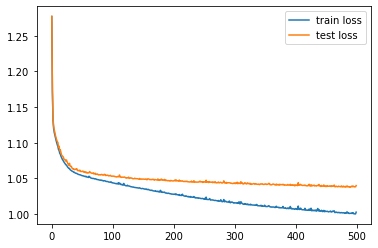

In [9]:
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()

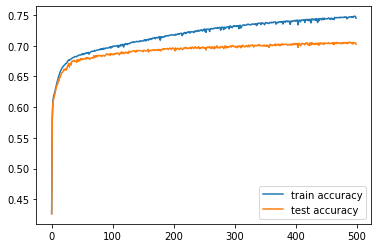

In [10]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(test_accuracies, label = "test accuracy")
plt.legend()